In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [ ]:
df=pd.read_csv("NVIDIA_Stock.csv")

In [ ]:
df = df[list(df)[-11:]]
df.shape

(260, 11)

In [ ]:
n_past = 10
n_future = 5 
n_features = 11

In [ ]:
260*.75

195.0

In [ ]:
train_df,test_df = df[0:195], df[195:]  # 75% and 25%
train_df.shape,test_df.shape

((195, 11), (65, 11))

In [ ]:
train = train_df
test = test_df

In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
X_test.shape

(51, 10, 11)

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(512,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(512, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(512, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10, 11)]     0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 10, 512), (N 1073152     input_4[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 512), (None, 2099200     lstm_11[0][0]                    
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 5, 512)       0           lstm_12[0][0]                    
____________________________________________________________________________________________

In [ ]:
#reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=700,validation_data=(X_test,y_test),batch_size=32,verbose=1)

Epoch 1/700
6/6 [==============================] - 10s 798ms/step - loss: 299.0763 - val_loss: 215.4418
Epoch 2/700
6/6 [==============================] - 3s 531ms/step - loss: 295.2372 - val_loss: 213.3658
Epoch 3/700
6/6 [==============================] - 3s 533ms/step - loss: 293.7525 - val_loss: 211.9187
Epoch 4/700
6/6 [==============================] - 3s 522ms/step - loss: 292.4993 - val_loss: 210.4999
Epoch 5/700
6/6 [==============================] - 3s 531ms/step - loss: 291.2738 - val_loss: 209.1811
Epoch 6/700
6/6 [==============================] - 3s 537ms/step - loss: 290.0666 - val_loss: 207.8293
Epoch 7/700
6/6 [==============================] - 3s 519ms/step - loss: 288.8473 - val_loss: 206.4690
Epoch 8/700
6/6 [==============================] - 3s 519ms/step - loss: 287.6396 - val_loss: 205.1081
Epoch 9/700
6/6 [==============================] - 3s 534ms/step - loss: 286.4433 - val_loss: 203.7445
Epoch 10/700
6/6 [==============================] - 3s 521ms/step - loss

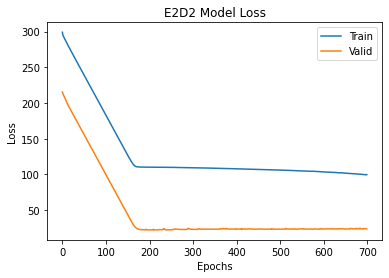

In [ ]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
pred1_e2d2=model_e2d2.predict(X_test)

In [ ]:
pred1_e2d2[0,:,-1].shape

(5,)

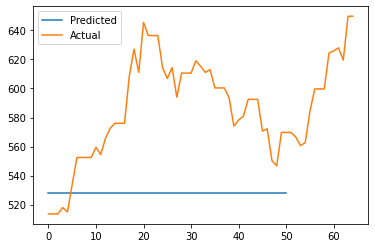

In [ ]:
plt.plot(pred1_e2d2[:,0,-1],label="Predicted")
plt.plot(range(len(test_df)),test_df["Close"],label="Actual")
plt.legend()
plt.show()

In [ ]:
pred1_e2d2[:,0,-1]

array([528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 ,
       528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 ,
       528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.28015,
       528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 ,
       528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 ,
       528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 ,
       528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 ,
       528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 , 528.2802 ,
       528.2802 , 528.2802 , 528.2802 ], dtype=float32)

In [22]:
model_e2d2.save('nvidia1.h5')

In [23]:
model_e2d2.evaluate(X_test,y_test)

2/2 [==============================] - 0s 84ms/step - loss: 23.9045


23.90453338623047